In [5]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import pickle
from pymoo.indicators.hv import HV
from pymoo.config import Config
Config.warnings['not_compiled'] = False
from problem import get_problem

In [6]:
color_code = ['darkcyan', 'grey', 'red', 'olive', 'brown', 'green', 'purple']

methods = ['DGEMO', 'MOEAD-EGO', 'TS-TCH', 'USEMO-EI', 'TSEMO', 'PSL-MOBO', 'Co-PSL']

problem_names = ['DTLZ2', 'VLMOP2', 'F2', 'RE33', 'RE36', 'RE37']

problem_display_name = ['DTLZ2', 'VLMOP2', 'F2', 'Disk Brake (RE33)', 'Gear Train (RE36)', 'Rocket Injector (RE37)']

font_size = 20

In [7]:
def HV_compute():
    for problem_name in problem_names:
        log_dir = f"weight/{problem_name}"

        n_dim = 6 if problem_name in ['F2', 'DTLZ2', 'VLMOP2'] else 4
        
        problem = get_problem(problem_name)
        ref_point = problem.nadir_point 
        ref_point = [1.1 * x  for x in ref_point]
        hv = HV(ref_point=np.array(ref_point))
        
        for method in methods:
            sol = np.load(f'{log_dir}/evaluation_{problem_name}_Y_{n_dim}_{method}.npy')
            print(f"{problem_name} - {method} - {sol.shape}")
            for i in range(sol.shape[0]): 
                hv_tmp = []
                for j in range(sol.shape[1]):
                    hv_tmp.append(hv(sol[i][:j])) 
                hv_tmp = np.expand_dims(hv_tmp, 0)
                hv_result = hv_tmp if i == 0 else np.vstack([hv_result, hv_tmp])
            print(hv_result.shape)
            np.save(f'{log_dir}/HV_{problem_name}_Y_{n_dim}_{method}.npy', hv_result)    

/tmp/ipykernel_150163/4184186799.py:3: UserWarning: The figure layout has changed to tight
  fig.tight_layout(pad=5.0)


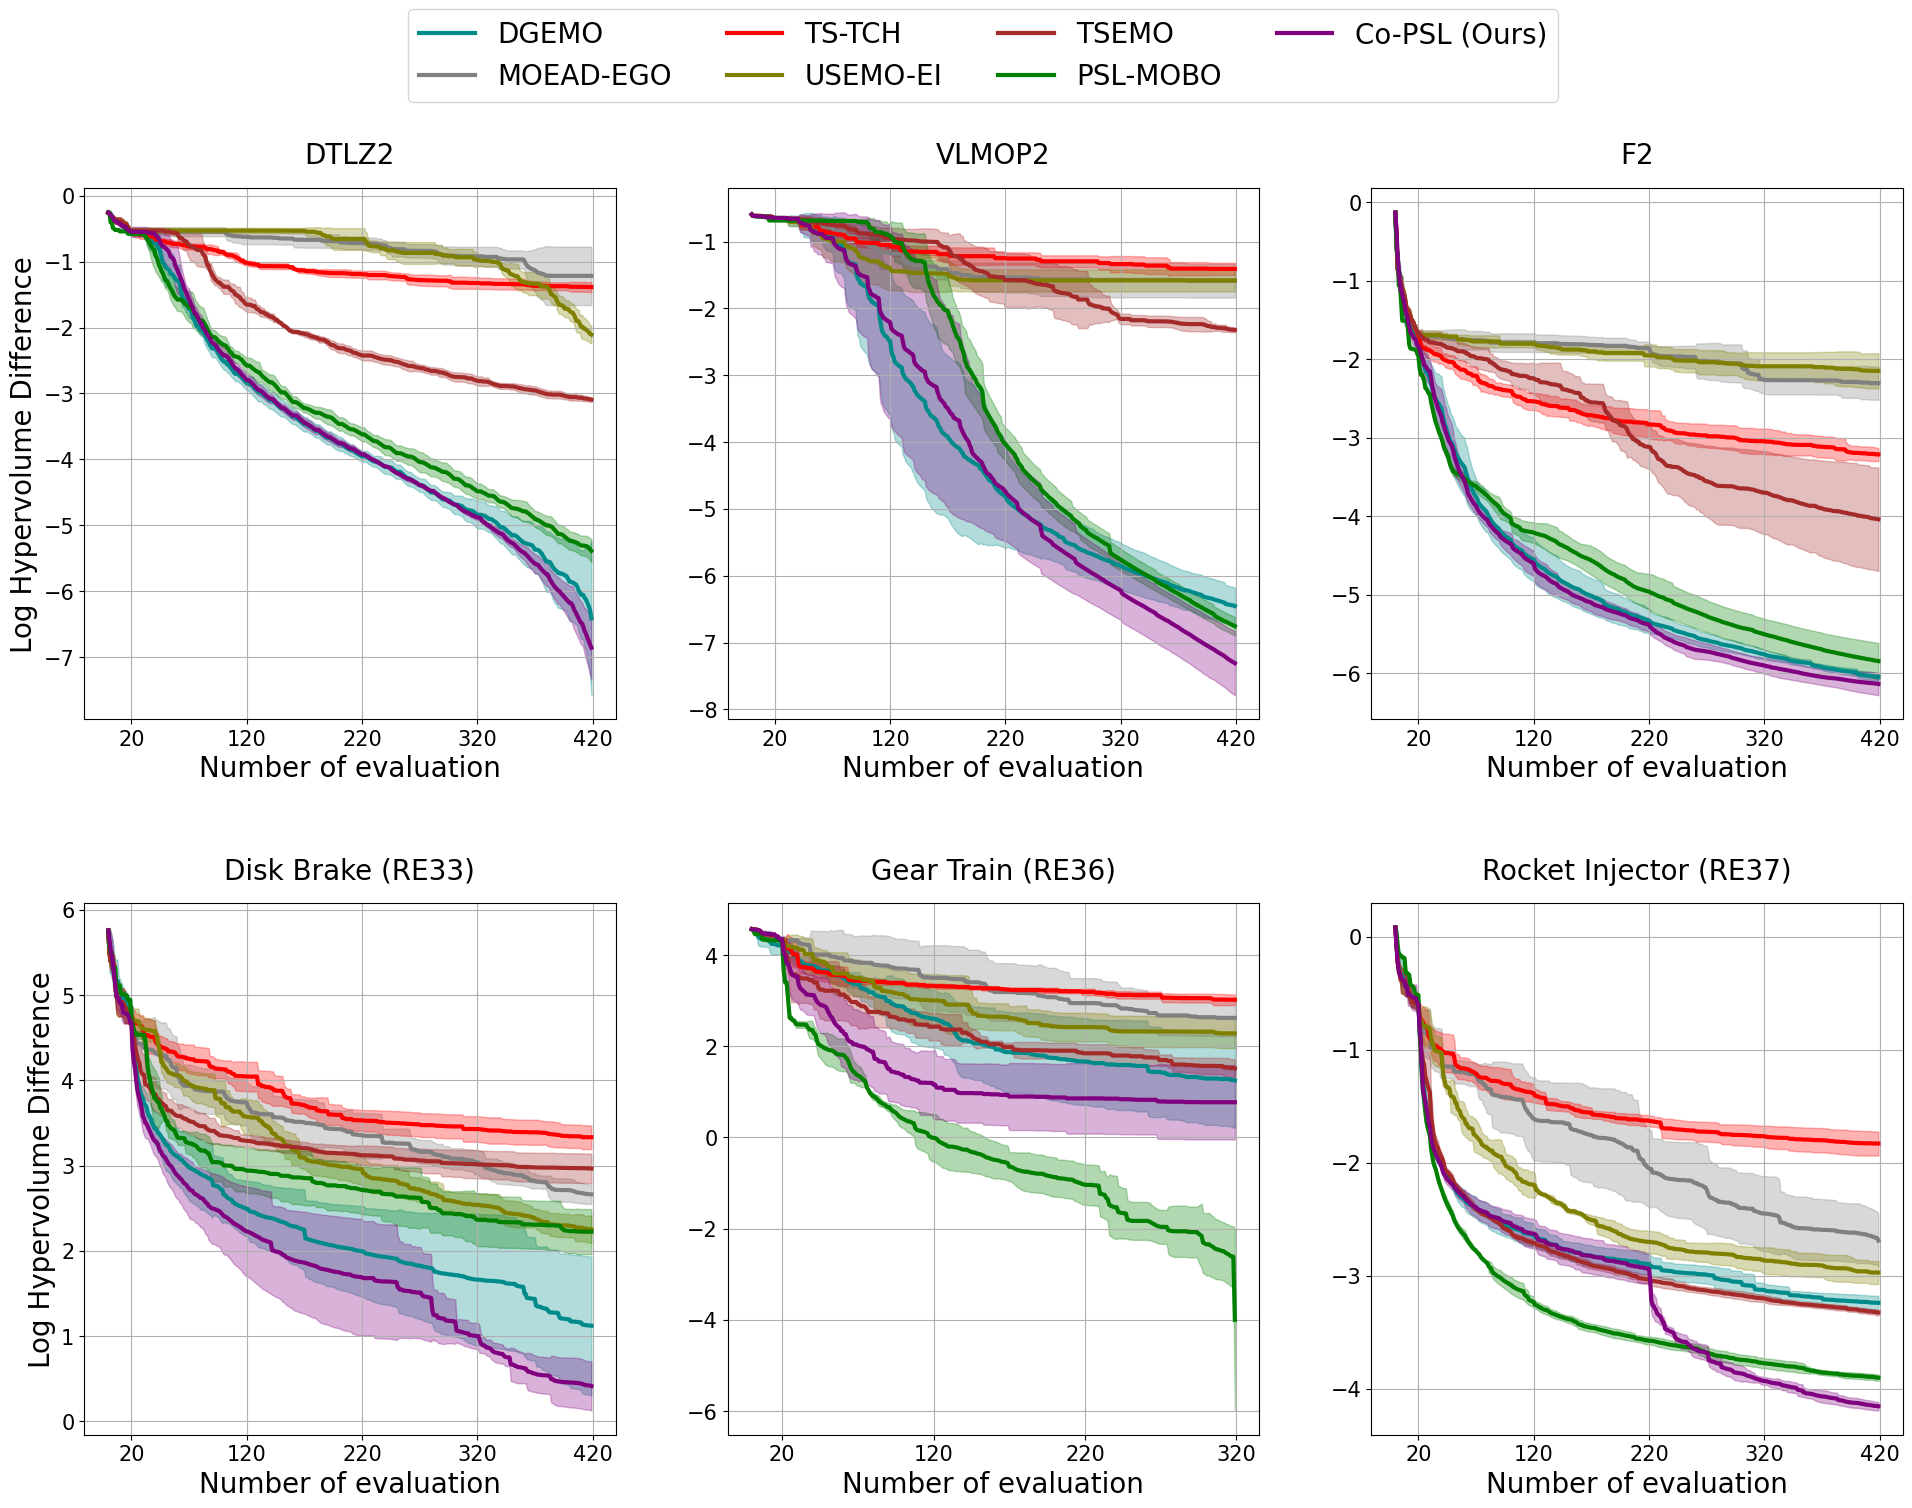

In [8]:
fig, axs = plt.subplots(figsize = (20, 15), ncols = 3, nrows=2, layout="constrained")
axs = axs.flatten()
fig.tight_layout(pad=5.0)
for index, problem_name in enumerate(problem_names):
    axs[index].set_box_aspect(1)
    log_dir = f"weight/{problem_name}"
    n_dim = 6 if problem_name in ['F2', 'DTLZ2', 'VLMOP2'] else 4
    problem = get_problem(problem_name)
    ref_point = problem.nadir_point 
    ref_point = [1.1 * x  for x in ref_point]
    hv = HV(ref_point=np.array(ref_point))
    truth_pareto = np.load(f'{log_dir}/TrueParetoFront.npy') 
    max_HV = hv(truth_pareto)
    for k, method in enumerate(methods):
        hv_results = np.load(f'{log_dir}/HV_{problem_name}_Y_{n_dim}_{method}.npy')
        n_eval = 420
        if problem_name == "RE36":
            hv_results = hv_results[:, :320]
            n_eval = 320

        if method == "Co-PSL": method = "Co-PSL (Ours)"
        LHV = np.log(np.clip(max_HV - hv_results, a_min=1e-14, a_max=max_HV))
        LHV_mean = np.mean(LHV,0)
        LHV_var = np.std(LHV, 0)
        
        axs[index].plot(LHV_mean, color=color_code[k], linewidth=3, label=f"{method}" if index == 0 else "")
        axs[index].fill_between(np.arange(0, n_eval, 1), LHV_mean - LHV_var, LHV_mean + LHV_var, color=color_code[k], alpha = 0.3)
    
    if index in [0, 3]:
        axs[index].set_ylabel("Log Hypervolume Difference", fontsize=font_size)
    axs[index].set_xlabel("Number of evaluation", fontsize=font_size)
    if problem_name == "RE36":
        x_label = [20, 120, 220, 320]
    else:
        x_label = [20, 120, 220, 320, 420] 
    axs[index].set_xticks(x_label)
    axs[index].tick_params(axis='both', labelsize=font_size - 5)
    axs[index].grid()
    axs[index].set_title(f"{problem_display_name[index]}", y = 1.03, fontsize=font_size)
fig.legend(loc="upper center", bbox_to_anchor=(0.5, 1.05), ncols=4, fontsize=font_size)
plt.savefig(f"visualization_plot/Result_LHD_final.pdf", bbox_inches='tight')
plt.show()